# Regresión logística con Python

En esta parte trabajaremos con el [Conjunto de Datos Titanic de Kaggle](https://www.kaggle.com/c/titanic). ¡Este es un conjunto de datos muy famoso y muy a menudo es el primer paso de un estudiante en el aprendizaje automático!

Trataremos de predecir una clasificación: supervivencia o muerte.
Comencemos nuestra comprensión de la implementación de Regresión logística en Python para clasificación.

Usaremos una versión "semi-limpia" del conjunto de datos Titanic, si usa el conjunto de datos alojado directamente en Kaggle, es posible que necesite realizar una limpieza adicional que no se muestra en este notebook.

## Importación de Librerias
Vamos a importar algunas de las librerias para comenzar!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Los datos

Comencemos leyendo el archivo titanic_train.csv en un dataframe de pandas.

In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Análisis exploratorio de datos

Hagamos análisis de datos exploratorio, ¡Comenzaremos por verificar los datos que faltan!

## Datos perdidos

¡Podemos usar Seaborn para crear un mapa de calor simple para ver dónde nos faltan datos!

<AxesSubplot:>

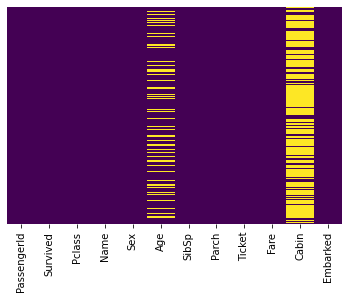

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Aproximadamente el 20 por ciento de los datos Age falta. La proporción de datos Age faltantes es probablemente lo suficientemente pequeña para un reemplazo razonable con alguna forma de imputación. Al mirar la columna Cabin, parece que se está perdiendo demasiados datos para hacer algo útil a un nivel básico. Probablemente lo eliminaremos más tarde o lo cambiemos a otra característica como "Cabina Conocida: 1 or 0".

<AxesSubplot:xlabel='Survived', ylabel='count'>

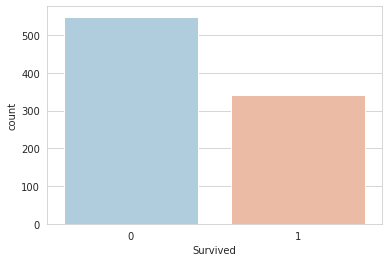

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

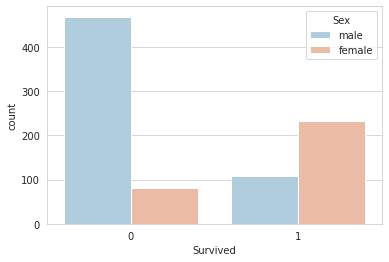

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

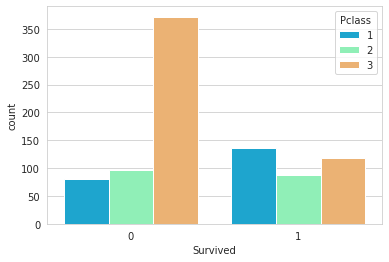

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

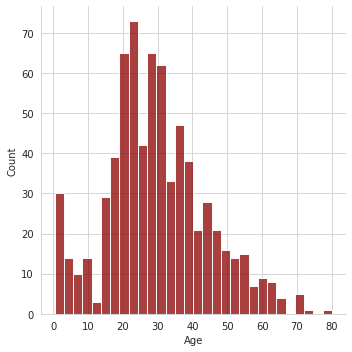

In [9]:
sns.displot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<AxesSubplot:>

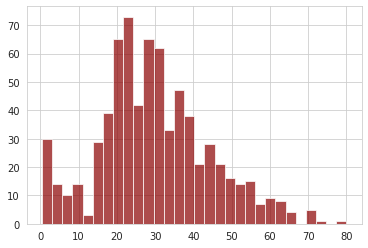

In [10]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

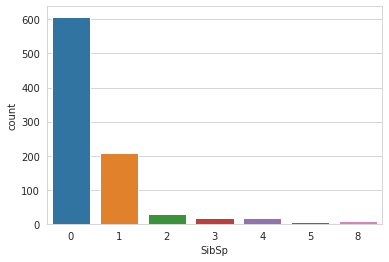

In [11]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

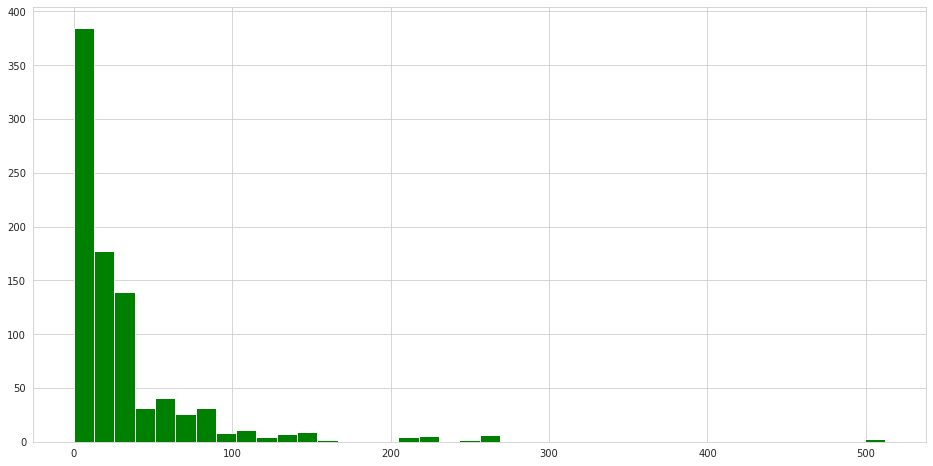

In [12]:
train['Fare'].hist(color='green',bins=40,figsize=(16,8))

___
## Limpieza de datos
Queremos completar los datos de edad faltantes en lugar de simplemente eliminar las filas con datos de edad faltantes. Una forma de hacerlo es rellenándolos con la edad promedio de todos los pasajeros (imputación).
Sin embargo, podemos ser más cuidadosos al respecto y verificar la edad promedio por clase de pasajeros. Por ejemplo:


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

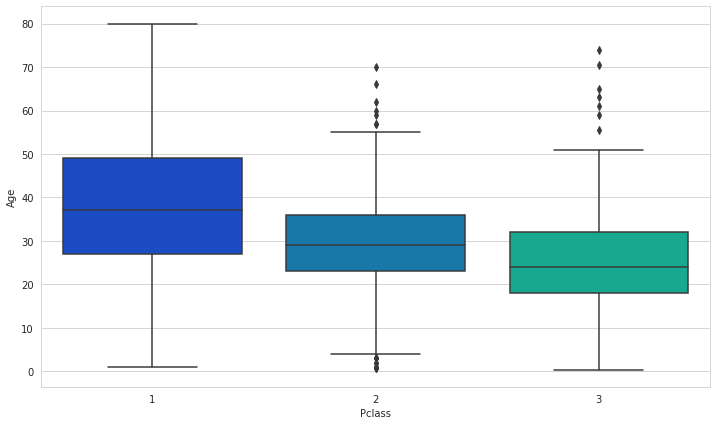

In [13]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [14]:
pasajeros_por_clase = train.groupby(['Pclass'])
pasajeros_por_clase['Age'].quantile([0.25,0.50,0.75])

Pclass      
1       0.25    27.0
        0.50    37.0
        0.75    49.0
2       0.25    23.0
        0.50    29.0
        0.75    36.0
3       0.25    18.0
        0.50    24.0
        0.75    32.0
Name: Age, dtype: float64

In [15]:
pasajeros_por_clase['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Podemos ver que los pasajeros más ricos en las clases superiores tienden a ser mayores, lo que tiene sentido. Utilizaremos estos valores de edad promedio para imputar Age según Pclass.

In [16]:
def imputar_edad(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

¡Ahora apliquemos está función!

In [17]:
train['Age'] = train[['Age','Pclass']].apply(imputar_edad,axis=1)

¡Ahora vamos a revisar el mapa de calor de nuevo!

<AxesSubplot:>

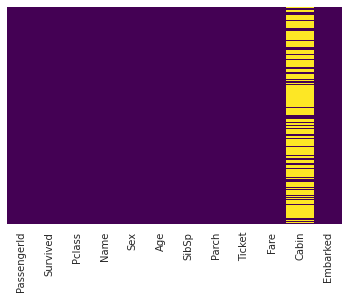

In [18]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

¡Estupendo! Avancemos y eliminemos la columna Cabin y la fila de Embarked que es NaN.

In [19]:
train.drop('Cabin',axis=1,inplace=True)

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [21]:
train.dropna(inplace=True)

## Conversión de características categóricas

¡Necesitamos convertir características categóricas a variables dummy usando pandas! De lo contrario, nuestro algoritmo de aprendizaje automático no podrá tomar directamente esas características como entradas.

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [24]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [25]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [26]:
train = pd.concat([train,sex,embark],axis=1)

In [27]:
train.head(15)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
5,6,0,3,24.0,0,0,8.4583,1,1,0
6,7,0,1,54.0,0,0,51.8625,1,0,1
7,8,0,3,2.0,3,1,21.0750,1,0,1
8,9,1,3,27.0,0,2,11.1333,0,0,1
9,10,1,2,14.0,1,0,30.0708,0,0,0


¡Estupendo! ¡Nuestros datos están listos para nuestro modelo!

# Construcción del modelo de Regresión Logística

Comencemos dividiendo nuestros datos en un conjunto de entrenamiento y un conjunto de pruebas (hay otro archivo test.csv que puede usar en caso de que desee utilizar todos estos datos para el entrenamiento).

## División de datos de entrenamiento y prueba

In [28]:
from sklearn.model_selection import train_test_split

In [31]:
print(train.drop('Survived',axis=1))
print("\n\n")
train['Survived']

     PassengerId  Pclass   Age  SibSp  Parch     Fare  male  Q  S
0              1       3  22.0      1      0   7.2500     1  0  1
1              2       1  38.0      1      0  71.2833     0  0  0
2              3       3  26.0      0      0   7.9250     0  0  1
3              4       1  35.0      1      0  53.1000     0  0  1
4              5       3  35.0      0      0   8.0500     1  0  1
..           ...     ...   ...    ...    ...      ...   ... .. ..
886          887       2  27.0      0      0  13.0000     1  0  1
887          888       1  19.0      0      0  30.0000     0  0  1
888          889       3  24.0      1      2  23.4500     0  0  1
889          890       1  26.0      0      0  30.0000     1  0  0
890          891       3  32.0      0      0   7.7500     1  1  0

[889 rows x 9 columns]





0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Entrenamiento y predicción

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/home/alex/Documentos/ApuntesSM/CICLO-VII/IA/Parte_practica/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
predictions = logmodel.predict(X_test)

In [31]:
y_test

511    0
613    0
615    1
337    1
718    0
      ..
792    0
828    1
732    0
669    1
634    0
Name: Survived, Length: 267, dtype: int64

In [32]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
511,512,3,24.0,0,0,8.05,1,0,1
613,614,3,24.0,0,0,7.75,1,1,0
615,616,2,24.0,1,2,65.00,0,0,1
337,338,1,41.0,0,0,134.50,0,0,0
718,719,3,24.0,0,0,15.50,1,1,0
...,...,...,...,...,...,...,...,...,...
792,793,3,24.0,8,2,69.55,0,0,1
828,829,3,24.0,0,0,7.75,1,1,0
732,733,2,29.0,0,0,0.00,1,0,1
669,670,1,37.0,1,0,52.00,0,0,1


In [33]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

¡Pasemos a evaluar nuestro modelo!

## Evaluación

¡Podemos verificar la precisión, recuperación, puntaje f1 usando el informe de clasificación!

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
confusion_matrix(y_test,predictions)

array([[149,  14],
       [ 39,  65]])

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.82      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.81      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



¡No esta mal! Es posible que desee explorar otra ingeniería de características y el otro archivo titanic_text.csv, algunas sugerencias para la ingeniería de características:

* Intente usar el título (Dr., Mr., Mrs, etc.) del nombre como una característica
* Tal vez la letra Cabin podría ser una característica
* ¿Hay alguna información desde la que se pueda obtener del boleto?

## ¡Gran trabajo!